# Tree tomography - November 12, 2023

This covers work with the 2x4 of Science(tm), where we drilled some holes to see how the time-of-flight was affected.

In [1]:
from datetime import datetime, timedelta
import json
import math
import pytz

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
# import scipy
import scipy.stats as st
# pd.set_option('max_columns', 50)

mpl.style.use('ggplot')

%matplotlib inline

# Today's data

- first run: no holes
  - second run: hole #1
  - either this one or 3rd, had to re-clamp sensor B; came loose & fell out.  Does not seem to have made a big difference.
- third run: hole #2
- fourth run: hole #3
- fifth run: six more holes

TODO: Add pictures


In [2]:
df_first_run = pd.read_csv("first_run.csv")
df_second_run = pd.read_csv("second_run.csv")
df_third_run = pd.read_csv("third_run.csv")
df_fourth_run = pd.read_csv("fourth_run.csv")
df_fifth_run = pd.read_csv("fifth_run.csv")

df = pd.DataFrame()
df["no_holes"] = df_first_run["A->B"]
df["one_hole"] = df_second_run["A->B"]
df["three_holes"] = df_third_run["A->B"]
df["nine_holes"] = df_fourth_run["A->B"]

Let's start with some plots!  I'm going to start with the A->B measurements.

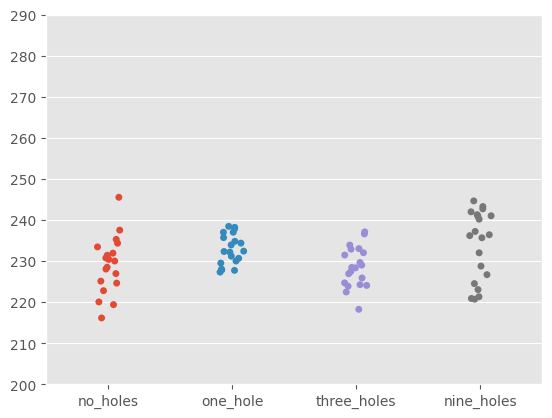

In [10]:
# sns.set(rc={"figure.figsize":(16, 16)}) #width=8, height=4

line_plot = sns.stripplot(data=df) # .set(title="Sensor 1 -> 2 in Log o' Science", ylabel="microseconds")
plt.yticks([y for y in range(200, 300, 10)])

fig = line_plot.get_figure()
fig.savefig('my_lineplot.png')

# First impressions
* I'd like to get some confidence values, but really, I need a lot more data.  20 datapoints are not enough.
* The nine_holes data does show an increase, but that splay really makes me wonder.

Let's take a look at mean, std deviation, and confidence intervals. 

In [4]:
min = 200
max = 300
def get_mean_and_std_in_cluster(df: pd.DataFrame, col: str, min: float = min, max: float = max) -> (float, float):
    """Get the mean of a column in df where its 
    values are between min and max.

    Helpful for getting the mean of a cluster, 
    rather than the mean of the whole column.

    Args:
      df: dataframe
      col: name of column in dataframe
      min: min range
      max: max range

    Returns:
      tuple(float, float): mean and stddev of values in that range
    """
    idx = df[col].between(min, max, inclusive="both")
    # print(idx)
    return (
        df[col][idx].mean(),
        df[col][idx].std(),
    )

for col in df.columns:
    print(f"{col}: ", end="")
    print(get_mean_and_std_in_cluster(df, col))

no_holes: (229.12800000000001, 6.779468695220419)
one_hole: (232.79900000000004, 3.7568098168525905)
three_holes: (228.48799999999997, 4.904869331378235)
nine_holes: (233.94399999999996, 8.447650810167659)


This tool: https://www.omnicalculator.com/statistics/confidence-interval takes into account population size.  I'm going to implement that function here.

(Further ref:: https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Foundations_in_Statistical_Reasoning_(Kaslik)/06%3A_Confidence_Intervals_and_Sample_Size)

In [7]:
P95_ZSCORE = 1.959964

def another_confidence_interval(df: pd.DataFrame, col: str, min: float = min, max: float = max, zscore: float = P95_ZSCORE):
    """Get confidence interval, following example at 
    https://www.omnicalculator.com/statistics/confidence-interval
    """
    mean, std = get_mean_and_std_in_cluster(df, col, min, max)
    # z * (s / n^0.5)
    n = len(df[col].dropna())
    ci = zscore * (std / math.sqrt(n))
    print(f"{mean:.2f} +/- {ci:.2f} ({n=}, {std=})")


for col in df.columns:
    print(f"{col}: ", end="") 
    another_confidence_interval(df, col, min=200, max=300)
    print()

no_holes: 229.13 +/- 2.97 (n=20, std=6.779468695220419)

one_hole: 232.80 +/- 1.65 (n=20, std=3.7568098168525905)

three_holes: 228.49 +/- 2.15 (n=20, std=4.904869331378235)

nine_holes: 233.94 +/- 3.70 (n=20, std=8.447650810167659)



Interesting; I think we see a higher measurement for three holes, but we definitely need more data. 

<Axes: >

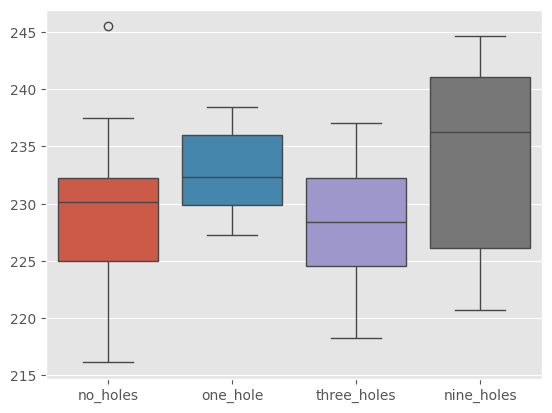

In [8]:
sns.boxplot(df)

<Axes: >

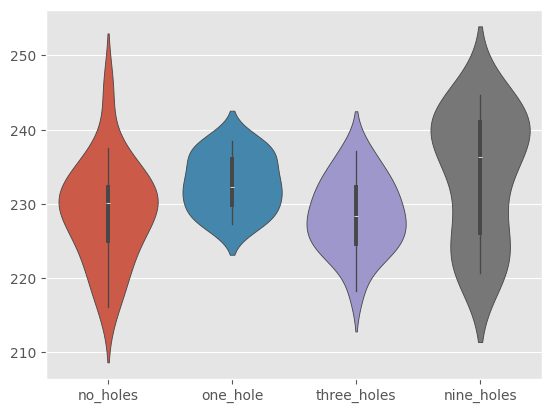

In [9]:
sns.violinplot(df)

Suggestion from a coworker: how is the three hole data distributed through time?  Is there something about the testing rig that might change over time?  Do all the large values come toward the beginning or end of the run?

In [24]:
df

,no_holes,one_hole,three_holes,nine_holes
0,245.50,234.34,223.84,226.66
1,237.50,237.00,218.22,223.02
2,233.42,232.38,224.04,220.68
3,230.72,230.64,222.44,221.28
4,230.38,233.90,225.86,220.86
5,224.60,236.98,224.22,224.48
6,226.92,238.18,224.66,231.98
7,222.76,235.68,232.00,228.74
8,228.46,237.82,226.88,237.18
9,228.02,234.78,227.44,236.16


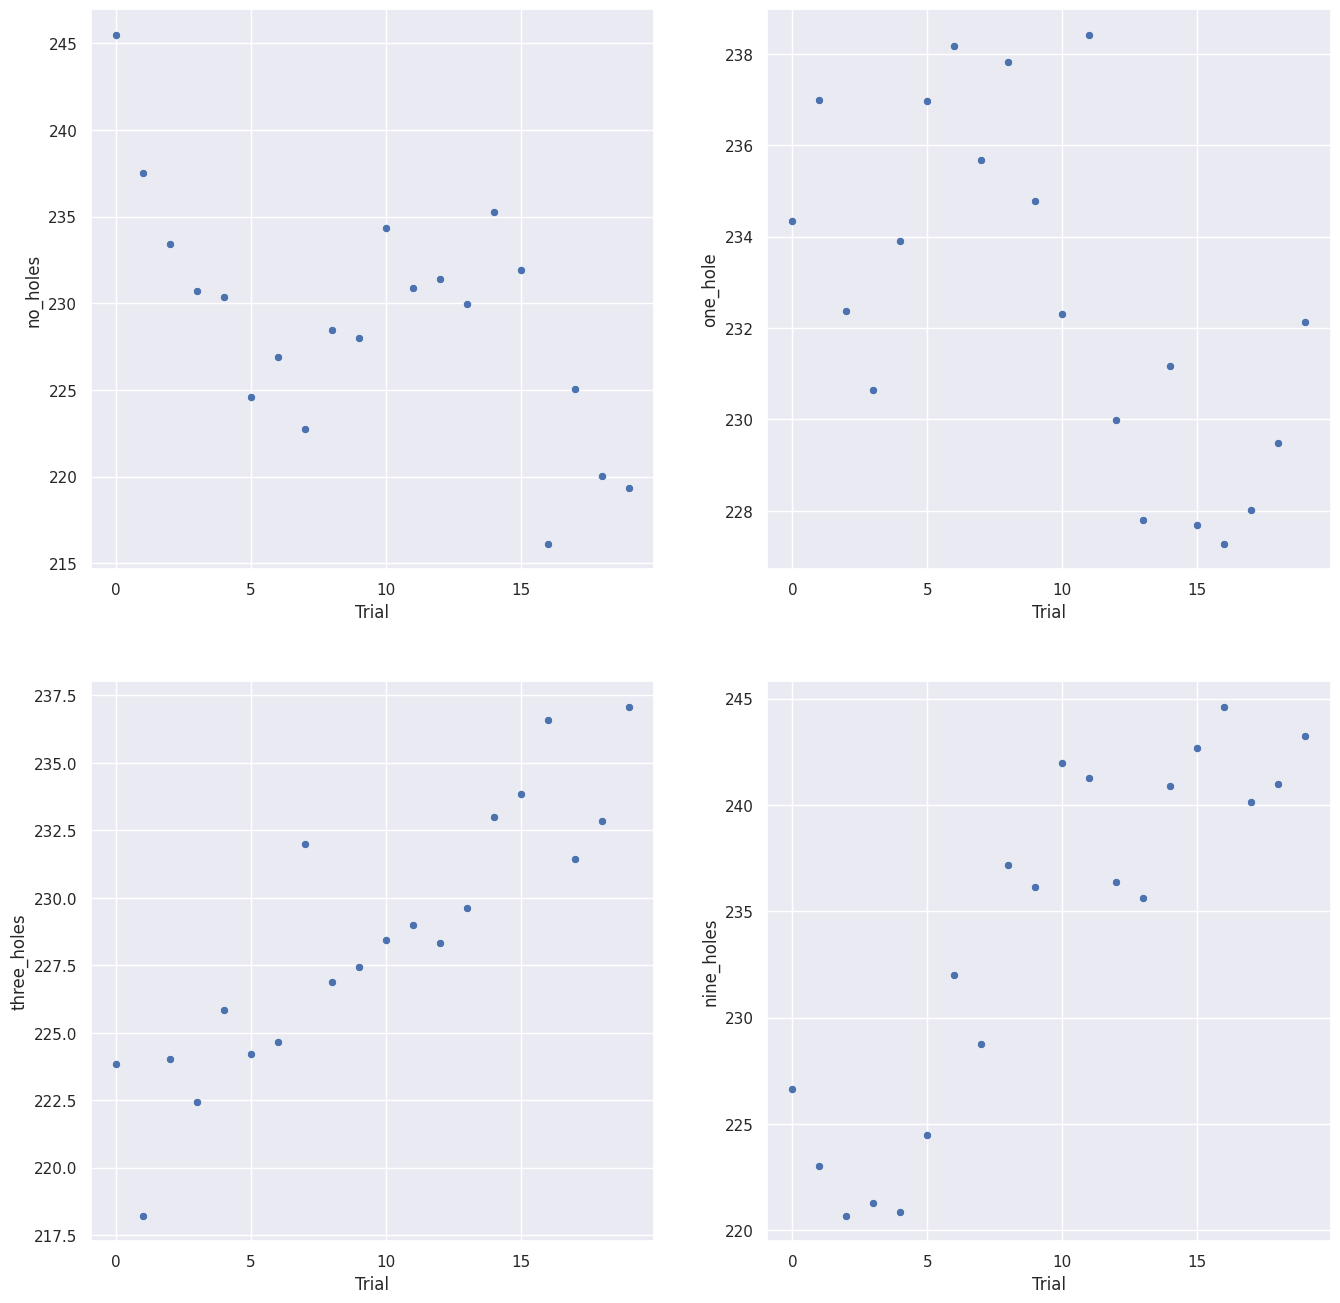

In [39]:
fig, ax = plt.subplots(2, 2)

sns.scatterplot(data=df, x=df.index, y='no_holes', ax=ax[0,0])
sns.scatterplot(data=df, x=df.index, y='one_hole', ax=ax[0,1])
sns.scatterplot(data=df, x=df.index, y='three_holes', ax=ax[1,0])
sns.scatterplot(data=df, x=df.index, y='nine_holes', ax=ax[1,1])

# fig.xticks([0, 5, 10, 15, 20])
for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set(xlabel="Trial", xticks=[0, 5, 10, 15])

Hm -- three_holes and nine_holes definitely seemed to get longer over time.  It would be worth digging into this.

In [11]:
from scipy.cluster.vq import kmeans, whiten

def kmeans_onecol(df: pd.DataFrame, col: str):
    """Do kmeans on just one column"""
    vals = df[df[col].isnull() == False][col]
    whitened = whiten(vals)
    codebook, distortion = kmeans(whitened, 2)
    print(codebook)
    plt.scatter(whitened, whitened)
    plt.scatter(codebook, codebook, c='r')
    plt.show()

[ 4.70759038 11.08669242]


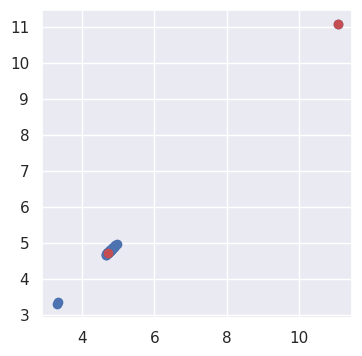

In [12]:
kmeans_onecol(df, "one_hole")

[1.81102203 4.45839465]


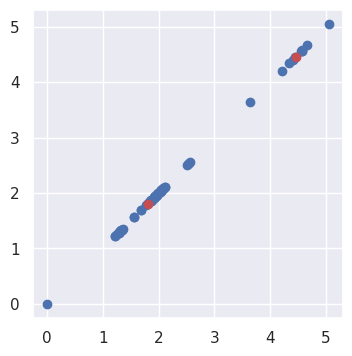

In [13]:
kmeans_onecol(df, "three_holes_MERGE")

In [14]:
df.columns

Index(['no_holes', 'one_hole', 'three_holes', 'three_holes_second_time',
       'three_holes_MERGE'],
      dtype='object')

Hm.  A couple things:

- this is worth investigating as a way to group plots.
- picked scipy method randomly.  how does this compare w/sklearn?
- how do I plot bounding box around group?
- not sure I understand at all how to do 2d kmeans clustering with my data.

# Is this data normally distributed?

I'd like to figure out if the data is normally distributed.  Let's plot some histograms.

<Axes: xlabel='nine_holes', ylabel='Count'>

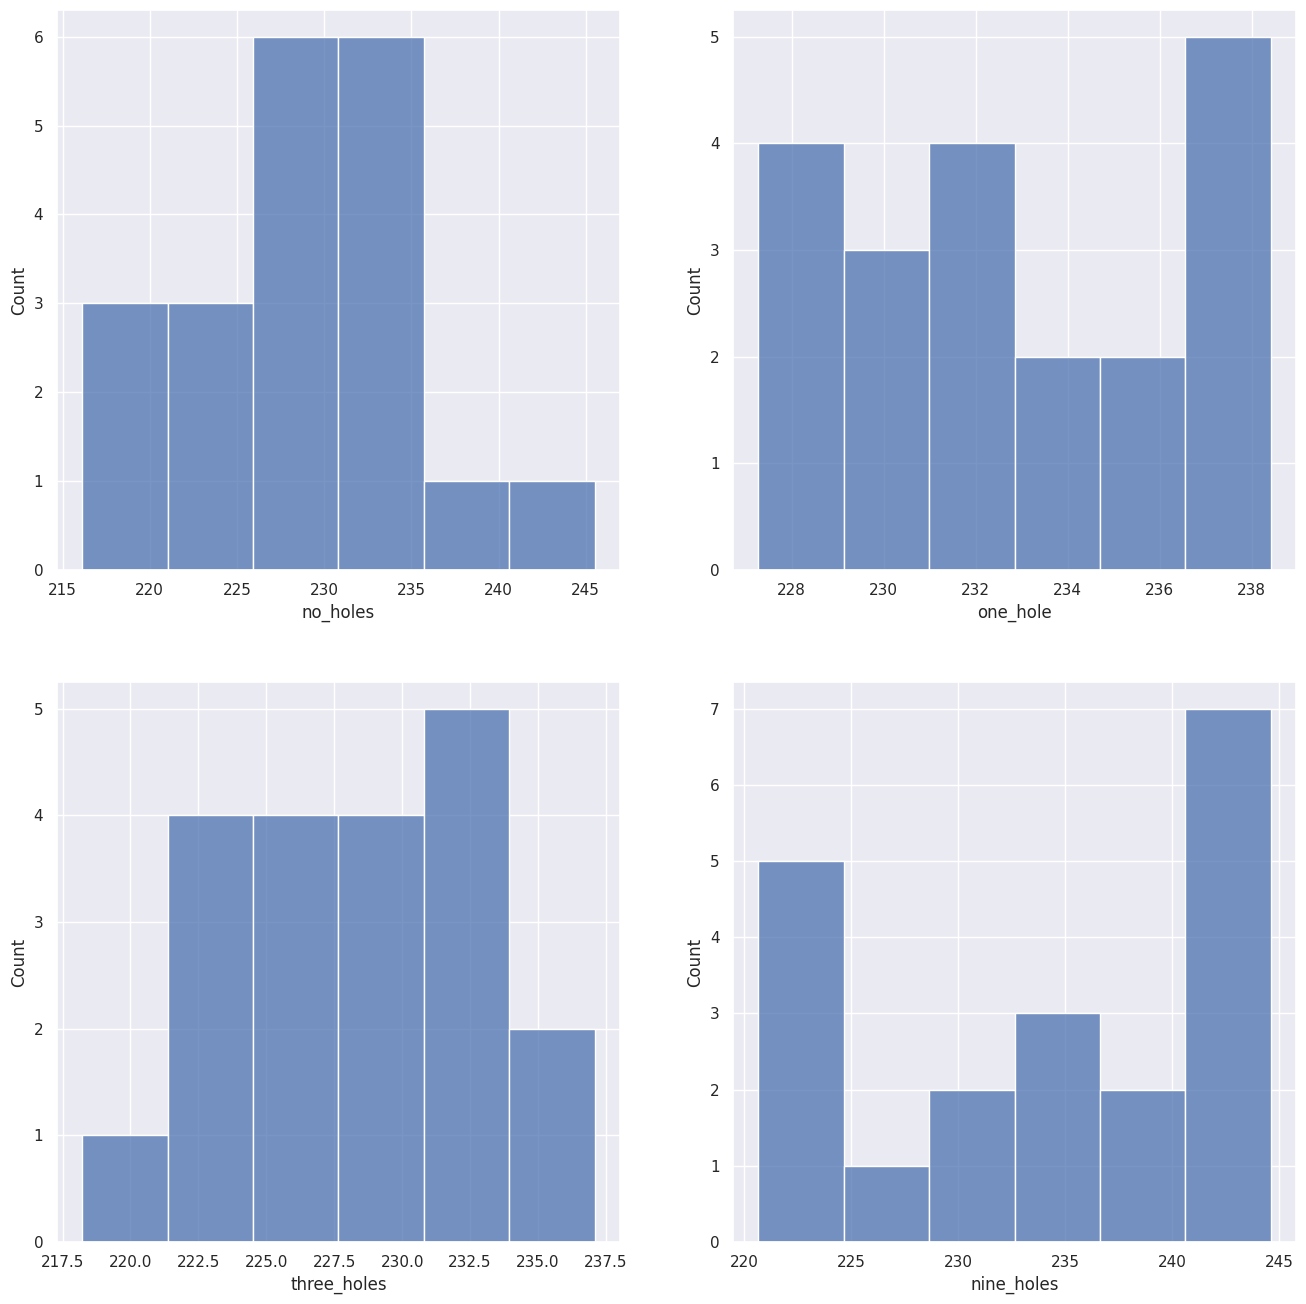

In [43]:
fig, ax = plt.subplots(2, 2)

sns.histplot(data=df, x='no_holes', ax=ax[0,0])
sns.histplot(data=df, x='one_hole', ax=ax[0,1])
sns.histplot(data=df, x='three_holes', ax=ax[1,0])
sns.histplot(data=df, x='nine_holes', ax=ax[1,1])

# fig.xticks([0, 5, 10, 15, 20])
# for i in [0, 1]:
#     for j in [0, 1]:
#         ax[i, j].set(xlabel="Trial", xticks=[0, 5, 10, 15])

There is simply not enough data to be confident.

Not enough data to tell.

# Conclusions

- Starting to get a better handle on basic statistics
- Definitely interesting differences
- NEED MOAR DATA